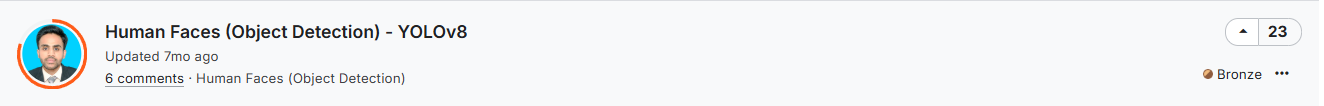

In [1]:
# Importing necessary libraries
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
import torch
import subprocess

# Install ultralytics
subprocess.run(["pip", "install", "ultralytics"])
from ultralytics import YOLO

In [2]:
# Import wandb and log in
import wandb

# Log in to wandb with API key
wandb.login(key='a96035366c44c4ac930354c4d3bda0f9499c339e')
# start a new wandb run to track this script
# 初始化 WandB
wandb.init(
    entity="huchencao08-shanghai-university",  # 替换为你的用户名或团队名称
    project="test",                       # 替换为你的项目名称
    config={
        "architecture": "YOLOV8",
        "epochs": 50
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Leaper\_netrc
wandb: Currently logged in as: huchencao08 (huchencao08-shanghai-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
# File paths
data_path = r"D:\code_study\ML_CODE\dataSets\ObjectDetection\Human_Faces_Object_Detection\archive"
data_path = data_path.replace("\\", "/")
image_dir = data_path + "/images"
csv_path = data_path + "/faces.csv"
output_dir = r"D:\code_study\ML_CODE\kaggle\ObjectDetection\Human Faces Object Detection\Human Faces (Object Detection) - YOLOv8\output"

In [4]:
# Load the dataset
faces_df = pd.read_csv(csv_path)

In [5]:
# EDA
print(faces_df.head())
print(faces_df.info())
print(faces_df.describe())

     image_name  width  height   x0   y0    x1   y1
0  00001722.jpg   1333    2000  490  320   687  664
1  00001044.jpg   2000    1333  791  119  1200  436
2  00001050.jpg    667    1000  304  155   407  331
3  00001736.jpg    626     417  147   14   519  303
4  00003121.jpg    626     418  462   60   599  166
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3350 entries, 0 to 3349
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  3350 non-null   object
 1   width       3350 non-null   int64 
 2   height      3350 non-null   int64 
 3   x0          3350 non-null   int64 
 4   y0          3350 non-null   int64 
 5   x1          3350 non-null   int64 
 6   y1          3350 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 183.3+ KB
None
             width       height           x0           y0           x1  \
count  3350.000000  3350.000000  3350.000000  3350.000000  3350.000000   
mean    967.96716

In [6]:
# Plot distribution of image widths and heights using Plotly
fig = px.histogram(faces_df, x='width', nbins=50, title='Distribution of Image Widths',
                   labels={'width': 'Image Width'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

fig = px.histogram(faces_df, x='height', nbins=50, title='Distribution of Image Heights',
                   labels={'height': 'Image Height'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

In [7]:
# Plot distribution of bounding box coordinates using Plotly
fig = px.histogram(faces_df, x='x0', nbins=50, title='Distribution of X0 Coordinates',
                   labels={'x0': 'X0 Coordinate'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

fig = px.histogram(faces_df, x='y0', nbins=50, title='Distribution of Y0 Coordinates',
                   labels={'y0': 'Y0 Coordinate'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

fig = px.histogram(faces_df, x='x1', nbins=50, title='Distribution of X1 Coordinates',
                   labels={'x1': 'X1 Coordinate'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

fig = px.histogram(faces_df, x='y1', nbins=50, title='Distribution of Y1 Coordinates',
                   labels={'y1': 'Y1 Coordinate'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

In [8]:
# Convert bounding box coordinates to YOLO format (normalized x_center, y_center, width, height)
def convert_to_yolo(row):
    dw = 1. / row['width']
    dh = 1. / row['height']
    x = (row['x0'] + row['x1']) / 2.0
    y = (row['y0'] + row['y1']) / 2.0
    w = row['x1'] - row['x0']
    h = row['y1'] - row['y0']
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return x, y, w, h

faces_df[['x', 'y', 'w', 'h']] = faces_df.apply(convert_to_yolo, axis=1, result_type='expand')

In [9]:
# Split the dataset into train and validation sets
train_df, val_df = train_test_split(faces_df, test_size=0.2, random_state=42)

In [10]:
# Create YOLO annotation files
annotations_dir = os.path.join(output_dir, 'annotations')
os.makedirs(annotations_dir, exist_ok=True)

for idx, row in faces_df.iterrows():
    annotation_path = os.path.join(annotations_dir, row['image_name'].replace('.jpg', '.txt'))
    with open(annotation_path, 'w') as f:
        f.write(f"0 {row['x']} {row['y']} {row['w']} {row['h']}\n")

In [11]:
# Function to create YOLO annotation files
def create_annotations(df, annotations_dir):
    os.makedirs(annotations_dir, exist_ok=True)
    for idx, row in df.iterrows():
        annotation_path = os.path.join(annotations_dir, row['image_name'].replace('.jpg', '.txt'))
        with open(annotation_path, 'w') as f:
            f.write(f"0 {row['x']} {row['y']} {row['w']} {row['h']}\n")

# Create YOLO annotation files for train and validation sets
train_annotations_dir = os.path.join(output_dir, 'train', 'labels')
val_annotations_dir = os.path.join(output_dir, 'val', 'labels')

create_annotations(train_df, train_annotations_dir)
create_annotations(val_df, val_annotations_dir)

In [12]:
# Image preprocessing
def preprocess_images(image_list, source_dir, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for img_name in image_list:
        img_path = os.path.join(source_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            target_path = os.path.join(target_dir, img_name)
            cv2.imwrite(target_path, img)

train_images_dir = os.path.join(output_dir, 'train', 'images')
val_images_dir = os.path.join(output_dir, 'val', 'images')

preprocess_images(train_df['image_name'].tolist(), image_dir, train_images_dir)
preprocess_images(val_df['image_name'].tolist(), image_dir, val_images_dir)

# Verify annotation files
print("Train annotations sample:")
print(os.listdir(train_annotations_dir)[:5])

print("Validation annotations sample:")
print(os.listdir(val_annotations_dir)[:5])

Train annotations sample:
['00000003.txt', '00000004.txt', '00000006.txt', '00000012.txt', '00000015.txt']
Validation annotations sample:
['00000005.txt', '00000008.txt', '00000011.txt', '00000018.txt', '00000023.txt']


In [13]:
yolo_model = YOLO('yolov8n.yaml') 

In [14]:
# Define the data.yaml file content dynamically
class_names = ['face']
data_yaml_content = f"""
train: {train_images_dir}
val: {val_images_dir}
nc: {len(class_names)}
names: {class_names}
"""

# Save the data.yaml file
data_yaml_path = os.path.join(output_dir, 'data.yaml')
with open(data_yaml_path, 'w') as f:
    f.write(data_yaml_content)

In [15]:
# Train the model
yolo_model.train(data=data_yaml_path, epochs=50, imgsz=640)

New https://pypi.org/project/ultralytics/8.3.78 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.65  Python-3.9.21 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=D:\code_study\ML_CODE\kaggle\ObjectDetection\Human Faces Object Detection\Human Faces (Object Detection) - YOLOv8\output\data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False

train: Scanning D:\code_study\ML_CODE\kaggle\ObjectDetection\Human Faces Object Detection\Human Faces (Object Detection) - YOLOv8\output\train\labels.cache... 1852 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1852/1852 [00:00<?, ?it/s]
val: Scanning D:\code_study\ML_CODE\kaggle\ObjectDetection\Human Faces Object Detection\Human Faces (Object Detection) - YOLOv8\output\val\labels.cache... 585 images, 0 backgrounds, 0 corrupt: 100%|██████████| 585/585 [00:00<?, ?it/s]


Plotting labels to runs\detect\train5\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.84G      3.126      3.923      3.896         21        640: 100%|██████████| 116/116 [00:29<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.52it/s]

                   all        585        585    0.00346      0.725     0.0134    0.00401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.85G      2.697      2.955      3.127         27        640: 100%|██████████| 116/116 [00:28<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.16it/s]

                   all        585        585      0.211      0.359      0.139     0.0501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.85G      2.308      2.459       2.77         24        640: 100%|██████████| 116/116 [00:28<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.13it/s]

                   all        585        585       0.37      0.387      0.321      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.85G      2.067      2.178       2.54         21        640: 100%|██████████| 116/116 [00:28<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.49it/s]

                   all        585        585      0.291      0.501      0.301      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.85G       1.93      2.045      2.403         25        640: 100%|██████████| 116/116 [00:29<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]

                   all        585        585      0.338      0.564      0.379      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.84G      1.792      1.925      2.285         25        640: 100%|██████████| 116/116 [00:29<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]

                   all        585        585      0.372      0.584      0.409      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.84G      1.723      1.828      2.218         17        640: 100%|██████████| 116/116 [00:29<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.75it/s]

                   all        585        585      0.397      0.451      0.403      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.84G      1.661      1.799      2.173         27        640: 100%|██████████| 116/116 [00:29<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.42it/s]

                   all        585        585      0.381       0.61      0.477      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.84G      1.624      1.722      2.128         25        640: 100%|██████████| 116/116 [00:29<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]

                   all        585        585      0.401      0.621      0.471      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.84G      1.585      1.725      2.089         25        640: 100%|██████████| 116/116 [00:28<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.03it/s]

                   all        585        585      0.426      0.561      0.485      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.84G      1.537      1.642       2.05         17        640: 100%|██████████| 116/116 [00:27<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.87it/s]

                   all        585        585      0.423      0.656      0.493      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.84G      1.494      1.584      2.016         27        640: 100%|██████████| 116/116 [00:27<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]

                   all        585        585      0.442      0.549      0.493      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.84G       1.47      1.575       1.99         29        640: 100%|██████████| 116/116 [00:27<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.37it/s]

                   all        585        585       0.38      0.614      0.454      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.84G      1.453      1.548      1.955         23        640: 100%|██████████| 116/116 [00:29<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.46it/s]

                   all        585        585      0.522      0.611      0.601      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.84G      1.439      1.516      1.927         26        640: 100%|██████████| 116/116 [00:29<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.89it/s]

                   all        585        585      0.466      0.627      0.542       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.84G      1.399       1.47       1.91         23        640: 100%|██████████| 116/116 [00:29<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.87it/s]

                   all        585        585      0.443      0.656      0.535      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.84G      1.393      1.465      1.901         22        640: 100%|██████████| 116/116 [00:29<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.60it/s]

                   all        585        585      0.519      0.521      0.544      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.84G       1.38      1.439      1.893         31        640: 100%|██████████| 116/116 [00:29<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.70it/s]

                   all        585        585      0.563      0.576      0.593      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.84G      1.346      1.375      1.855         21        640: 100%|██████████| 116/116 [00:29<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.72it/s]

                   all        585        585      0.571      0.615      0.621       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.84G      1.359      1.395      1.854         27        640: 100%|██████████| 116/116 [00:29<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.56it/s]

                   all        585        585      0.507      0.641      0.604      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.84G      1.327      1.373       1.82         28        640: 100%|██████████| 116/116 [00:30<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.92it/s]

                   all        585        585      0.539      0.578      0.582      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.84G      1.318      1.344       1.83         27        640: 100%|██████████| 116/116 [00:29<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.75it/s]

                   all        585        585      0.582       0.62       0.62      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.84G      1.309      1.316      1.801         35        640: 100%|██████████| 116/116 [00:29<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.85it/s]

                   all        585        585       0.62      0.586      0.642      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.84G      1.283      1.312      1.787         24        640: 100%|██████████| 116/116 [00:29<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.76it/s]

                   all        585        585      0.696      0.528      0.673      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.84G      1.308      1.316      1.813         19        640: 100%|██████████| 116/116 [00:29<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.68it/s]

                   all        585        585      0.551      0.627       0.62      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.84G      1.286      1.276      1.796         25        640: 100%|██████████| 116/116 [00:29<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.50it/s]

                   all        585        585      0.638      0.566      0.662      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.84G      1.265      1.287       1.78         25        640: 100%|██████████| 116/116 [00:29<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.24it/s]

                   all        585        585      0.542      0.642      0.658      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.84G       1.24       1.27      1.754         31        640: 100%|██████████| 116/116 [00:29<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]

                   all        585        585      0.597      0.584      0.648      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.84G       1.22      1.243      1.736         22        640: 100%|██████████| 116/116 [00:29<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.47it/s]

                   all        585        585      0.558      0.622      0.659      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.84G      1.228      1.245      1.736         22        640: 100%|██████████| 116/116 [00:29<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.72it/s]

                   all        585        585      0.561       0.59      0.637      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.84G      1.231      1.255      1.736         20        640: 100%|██████████| 116/116 [00:28<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.04it/s]

                   all        585        585      0.647      0.581      0.659      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.84G      1.215      1.196      1.727         25        640: 100%|██████████| 116/116 [00:28<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.38it/s]

                   all        585        585      0.654      0.591      0.686      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.84G      1.197      1.195      1.714         23        640: 100%|██████████| 116/116 [00:28<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.72it/s]

                   all        585        585       0.67      0.581      0.696       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.84G      1.198      1.175      1.698         25        640: 100%|██████████| 116/116 [00:27<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.89it/s]

                   all        585        585      0.724      0.538      0.699      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.84G      1.192      1.194      1.713         28        640: 100%|██████████| 116/116 [00:27<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.80it/s]

                   all        585        585      0.646      0.639      0.713      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.84G       1.19      1.199      1.711         22        640: 100%|██████████| 116/116 [00:27<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.73it/s]

                   all        585        585      0.639      0.612      0.695      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.84G      1.176      1.161       1.69         25        640: 100%|██████████| 116/116 [00:28<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]

                   all        585        585      0.698      0.545      0.691      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.84G      1.156      1.148      1.676         27        640: 100%|██████████| 116/116 [00:27<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]

                   all        585        585      0.672      0.639      0.723      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.84G      1.147      1.137      1.664         24        640: 100%|██████████| 116/116 [00:27<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.70it/s]

                   all        585        585      0.718      0.597       0.72      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.84G      1.141       1.12      1.657         17        640: 100%|██████████| 116/116 [00:27<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.68it/s]

                   all        585        585      0.695       0.61       0.72      0.501


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.84G      1.002     0.8991      1.608         12        640: 100%|██████████| 116/116 [00:28<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.76it/s]

                   all        585        585      0.707      0.586      0.727      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.84G     0.9853     0.8361      1.594         12        640: 100%|██████████| 116/116 [00:28<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]

                   all        585        585      0.665      0.622      0.746      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.84G      0.963     0.8321       1.58         12        640: 100%|██████████| 116/116 [00:29<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.62it/s]

                   all        585        585       0.69      0.632      0.756      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.84G     0.9467     0.8173      1.561         12        640: 100%|██████████| 116/116 [00:28<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.70it/s]

                   all        585        585      0.709      0.603       0.74      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.84G     0.9253     0.7951       1.54         12        640: 100%|██████████| 116/116 [00:28<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.76it/s]

                   all        585        585      0.715      0.622      0.765      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.84G     0.9233     0.7929      1.548         12        640: 100%|██████████| 116/116 [00:28<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.77it/s]

                   all        585        585       0.78      0.581      0.763      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.84G     0.9115     0.7777       1.53         12        640: 100%|██████████| 116/116 [00:28<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.67it/s]

                   all        585        585      0.763      0.578      0.773      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.84G      0.915     0.7805      1.519         12        640: 100%|██████████| 116/116 [00:28<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.68it/s]

                   all        585        585      0.756      0.609      0.771      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.84G     0.8884      0.752      1.504         12        640: 100%|██████████| 116/116 [00:28<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.68it/s]

                   all        585        585      0.691      0.634      0.771      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.84G     0.8731     0.7464       1.49         12        640: 100%|██████████| 116/116 [00:28<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.70it/s]

                   all        585        585      0.714       0.62      0.773      0.551



50 epochs completed in 0.459 hours.
Optimizer stripped from runs\detect\train5\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train5\weights\best.pt, 6.2MB

Validating runs\detect\train5\weights\best.pt...
Ultralytics 8.3.65  Python-3.9.21 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.87it/s]


                   all        585        585      0.714       0.62      0.773      0.551
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002744287B9D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [16]:
# Function to draw rounded rectangle
def draw_rounded_rectangle(img, start_point, end_point, color, thickness, radius):
    x1, y1 = start_point
    x2, y2 = end_point
    img = cv2.rectangle(img, (x1 + radius, y1), (x2 - radius, y2), color, thickness)
    img = cv2.rectangle(img, (x1, y1 + radius), (x2, y2 - radius), color, thickness)
    img = cv2.circle(img, (x1 + radius, y1 + radius), radius, color, thickness)
    img = cv2.circle(img, (x2 - radius, y1 + radius), radius, color, thickness)
    img = cv2.circle(img, (x1 + radius, y2 - radius), radius, color, thickness)
    img = cv2.circle(img, (x2 - radius, y2 - radius), radius, color, thickness)
    return img

# Display 10 sample images with detection results
def display_samples_with_detections(model, images_dir, samples=10):
    sample_images = os.listdir(images_dir)[:samples]
    for img_name in sample_images:
        img_path = os.path.join(images_dir, img_name)
        results = model(img_path)[0]  # Get the first (and only) Results object
        img = cv2.imread(img_path)
        for box in results.boxes.xyxy.cpu().numpy():  # x1, y1, x2, y2
            x1, y1, x2, y2 = map(int, box)
            img = draw_rounded_rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2, 10)  # Red color, thickness 2, radius 10
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

display_samples_with_detections(yolo_model, val_images_dir)

print("Process completed. Outputs are stored in:", output_dir)


image 1/1 D:\code_study\ML_CODE\kaggle\ObjectDetection\Human Faces Object Detection\Human Faces (Object Detection) - YOLOv8\output\val\images\00000005.jpg: 480x640 1 face, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


<Figure size 1000x1000 with 1 Axes>


image 1/1 D:\code_study\ML_CODE\kaggle\ObjectDetection\Human Faces Object Detection\Human Faces (Object Detection) - YOLOv8\output\val\images\00000008.jpg: 448x640 1 face, 17.2ms
Speed: 2.0ms preprocess, 17.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


<Figure size 1000x1000 with 1 Axes>


image 1/1 D:\code_study\ML_CODE\kaggle\ObjectDetection\Human Faces Object Detection\Human Faces (Object Detection) - YOLOv8\output\val\images\00000011.jpg: 448x640 (no detections), 4.0ms
Speed: 2.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


<Figure size 1000x1000 with 1 Axes>


image 1/1 D:\code_study\ML_CODE\kaggle\ObjectDetection\Human Faces Object Detection\Human Faces (Object Detection) - YOLOv8\output\val\images\00000018.jpg: 448x640 1 face, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


<Figure size 1000x1000 with 1 Axes>


image 1/1 D:\code_study\ML_CODE\kaggle\ObjectDetection\Human Faces Object Detection\Human Faces (Object Detection) - YOLOv8\output\val\images\00000023.jpg: 640x448 1 face, 17.6ms
Speed: 1.0ms preprocess, 17.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


<Figure size 1000x1000 with 1 Axes>


image 1/1 D:\code_study\ML_CODE\kaggle\ObjectDetection\Human Faces Object Detection\Human Faces (Object Detection) - YOLOv8\output\val\images\00000058.jpg: 416x640 2 faces, 21.6ms
Speed: 2.0ms preprocess, 21.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


<Figure size 1000x1000 with 1 Axes>


image 1/1 D:\code_study\ML_CODE\kaggle\ObjectDetection\Human Faces Object Detection\Human Faces (Object Detection) - YOLOv8\output\val\images\00000089.jpg: 640x448 1 face, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


<Figure size 1000x1000 with 1 Axes>


image 1/1 D:\code_study\ML_CODE\kaggle\ObjectDetection\Human Faces Object Detection\Human Faces (Object Detection) - YOLOv8\output\val\images\00000100.jpg: 640x448 1 face, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


<Figure size 1000x1000 with 1 Axes>


image 1/1 D:\code_study\ML_CODE\kaggle\ObjectDetection\Human Faces Object Detection\Human Faces (Object Detection) - YOLOv8\output\val\images\00000104.jpg: 640x480 1 face, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


<Figure size 1000x1000 with 1 Axes>


image 1/1 D:\code_study\ML_CODE\kaggle\ObjectDetection\Human Faces Object Detection\Human Faces (Object Detection) - YOLOv8\output\val\images\00000120.jpg: 640x448 1 face, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


<Figure size 1000x1000 with 1 Axes>

Process completed. Outputs are stored in: D:\code_study\ML_CODE\kaggle\ObjectDetection\Human Faces Object Detection\Human Faces (Object Detection) - YOLOv8\output
